Autor koda: Šimun Šopar

In [1]:
import os
from dataclasses import dataclass
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np

import torch.nn as nn
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

# Zadatak 1

In [2]:
@dataclass
class Instance:
    text: str
    sentiment: str  #positive, negative
    # prije: 0 = negative, 1 = positive

        
class NLPDataset(Dataset):
    def __init__(self, filepath):
        self.filepath = filepath #path do datoteke s tekstom
        self.data = []  #sav data, red po red, vrsta podataka je Instance
        self.frequencies = None #frekvencije pojedinih riječi, poredane od najčešće prema dolje
        self.sentiment_frequency = [0, 0] #frekvencija sentimenata
        self.common_sent = 0 #najčešći sentiment
        
    def __getitem__(self, index):
        if(index >= len(self.data)):
            print('Invalid index')
            return None
        else:
            data = self.data[index]
            #return data
            text = data.text
            sentiment = data.sentiment
            return text, sentiment
        
    def setData(self):
        with open(self.filepath, 'r') as f:
            for line in f:
                row = line.split(',')
                if(row[1][1] == 'p'):
                    sentiment = 'positive'
                else:
                    sentiment = 'negative'
                self.data.append(Instance(row[0], sentiment))
                
    def findFrequencies(self):
        all_text = ""
        for data in self.data:
            all_text += data.text + " "
            self.sentiment_frequency[sentimentToInt(data.sentiment)] += 1
        
        all_text = all_text.split() #dobivamo pojedine riječi
        counter = Counter(all_text)
        self.frequencies = counter.most_common()
        self.common_sent = np.argmax(self.sentiment_frequency)
        
    def getFrequencies(self):
        return self.frequencies
    
    def getSentimentFrequency(self):
        if(self.sentiment_frequency[0] == self.common_sent):
            return [0, 1]
        else:
            return [1, 0]


class Vocab:
    def __init__(self, frequencies, max_size, min_freq, mode = 'text'):
        #possible modes are text and sentiment
        
        self.stoi = None
        self.itos = None
        if(mode == 'text'):
            self.stoi = "<PAD>: 0\n<UNK>: 1\n"
            self.itos = "0: <PAD>\n1: <UNK>\n"
            index = 2
            
            if (max_size == -1):
                max_size = len(frequencies)
            
            for i in range(max_size):
                if(frequencies[i][1] >= min_freq):
                    self.stoi += frequencies[i][0] + ": " + str(index) + "\n"
                    self.itos += str(index) + ": " + frequencies[i][0] + "\n"
                    index += 1
                
                else:
                    break
            
        elif (mode == 'sentiment'):
            self.stoi = "negative: " + str(frequencies[0]) + "\npositive: " + str(frequencies[1]) + "\n"
            self.itos = str(frequencies[0]) + ": negative\n" + str(frequencies[1]) + ": positive\n"
            
        else:
            print('Please select correct mode')
            return
        
        
        

          
    def encode(self, token):
        if (type(token) == str):
            token = [token]
            
        elif(type(token) != list):
            print('Wrong input type, should be str or list')
            return
        
        output = np.ones(len(token))
        #token_copy = token.copy()
        #len_output = 0
        pop_indices = []
        for word in self.stoi.split('\n'):
            word_split = word.split(':')
            for i,s in enumerate(token):
                if(s == word_split[0] and i not in pop_indices):
                    output[i] = int(word_split[1])
                    pop_indices.append(i)
            if(len(pop_indices) == len(token)):
                break
                
        return torch.tensor(output).to(torch.int)
    

    
def sentimentToInt(sentiment): #deprecated
    if(sentiment == 'positive'):
        return 1
    elif(sentiment == 'negative'):
        return 0
    else:
        print('Incorrect value, should be "positive" or "negative"')
        
def sentimentToString(sentiment):
    if(sentiment == 0):
        return "negative"
    elif(sentiment == 1):
        return "positive"
    else:
        print('Incorrect sentiment value (should be 0 or 1)')
    

def getEmbeddedMatrix(vocab, mode = "normal", vec_represent = None):
    #support normal and glove mod
    #expects stoi as vocab parameter
    embed_matrix = []
    if(mode == "normal"):
        vocab = vocab.split('\n')
        vocab.pop(-1)
        for line in vocab:
            embed_matrix.append(np.random.normal(0, 1, 300))
        embed_matrix[0] = np.zeros(300)
        return np.array(embed_matrix)
        
        
    elif(mode == "glove"):
        if(vec_represent == None):
            print("You should add vector representation file if you use glove mode.")
            return
        
        vec_represent = vec_represent.split('\n')
        vec_represent.pop(-1)
        vec_words = []
        vec_matrix = []
        
        for vec in vec_represent:
            vec_split = vec.split()
            vec_words.append(vec_split[0])
            vec_matrix.append([(float)(v) for v in vec_split[1:]])
        
        vocab = vocab.split('\n')
        vocab.pop(-1)
        
        for line in vocab:
            word = line.split(':')
            word = word[0]
            if(word in vec_words):
                index = vec_words.index(word)
                embed_matrix.append(vec_matrix[index])
            else:
                embed_matrix.append(np.random.normal(0, 1, 300))
                #print(line.split(':')[0])
        
        embed_matrix[0] = np.zeros(300)
        return np.array(embed_matrix)
        
        
    else:
        print("Incorrect mode.")
        
        

def collate_fn(batch):  #batch je lista, jedan član liste se sastoji od jednog tenzora koji je tekst i jednog koji je sentiment
    texts = []
    labels = []
    lengths = []
    for b in batch:
        texts.append(b[0])
        labels.append(b[1])
        lengths.append(len(b[0]))
        
    return texts, torch.cat(labels), torch.tensor(lengths)
        

def pad_collate_fn(batch, pad_index = 0):
    texts, labels, lengths = collate_fn(batch)
    maxIndex = np.argmax(lengths)
    return torch.transpose(torch.nn.utils.rnn.pad_sequence(texts, padding_value = pad_index), 0, 1), labels, lengths

In [3]:
trainData = NLPDataset('data/sst_train_raw.csv')
trainData.setData()
trainData.findFrequencies()
freq = trainData.getFrequencies()

text_vocab = Vocab(freq, -1, 0)
label_vocab = Vocab(trainData.getSentimentFrequency(), -1, 0, 'sentiment')


print('Test 1: Najčešće riječi')
for i in range(5):
    print(freq[i])

print('\n\nTest 2: Numerikalizacija')
print(trainData.data[3].text)
print(text_vocab.encode(trainData.data[3].text.split()))

print()

print(trainData.data[3].sentiment)
print(label_vocab.encode(trainData.data[3].sentiment))


print('\n\nTest 3: Veličina rječnika')
print(len(text_vocab.stoi.split("\n")) - 1)  #-1 jer je zadnji red prazan

Test 1: Najčešće riječi
('the', 5954)
('a', 4361)
('and', 3831)
('of', 3631)
('to', 2438)


Test 2: Numerikalizacija
yet the act is still charming here
tensor([189,   2, 674,   7, 129, 348, 143], dtype=torch.int32)

positive
tensor([0], dtype=torch.int32)


Test 3: Veličina rječnika
14806


In [4]:
#pokretati samo jednom!
#loads dictionary
vec_represent = ''
with open('sst_glove_6b_300d.txt', 'r') as f:
    for line in f:
        vec_represent += line

In [5]:
#embedded matrix generation

#embed_matrix = getEmbeddedMatrix(text_vocab.stoi, 'normal')
embed_matrix = getEmbeddedMatrix(text_vocab.stoi, 'glove', vec_represent)
embed_matrix = nn.Embedding.from_pretrained(torch.Tensor(embed_matrix), padding_idx = 0, freeze = True)

In [6]:
print('Test: Embedded matrica')
print(embed_matrix(text_vocab.encode("the"))[0][:5])

Test: Embedded matrica
tensor([ 0.0466,  0.2132, -0.0074, -0.4585, -0.0356])


In [7]:
#izrada train seta
trainDataSentiment = [trainData.data[i].sentiment for i in range(len(trainData.data))]
trainDataText = [trainData.data[i].text.split() for i in range(len(trainData.data))]
encodeDataSentiment = [label_vocab.encode(x) for x in trainDataSentiment]
encodeDataText = [text_vocab.encode(x) for x in trainDataText]

trainSet = list(zip(encodeDataText, encodeDataSentiment))


In [8]:
#učitavanje test i eval podataka

testData = NLPDataset('data/sst_test_raw.csv')
testData.setData()

testDataSentiment = [testData.data[i].sentiment for i in range(len(testData.data))]
testDataText = [testData.data[i].text.split() for i in range(len(testData.data))]
encodeTestSentiment = [label_vocab.encode(x) for x in testDataSentiment]
encodeTestText = [text_vocab.encode(x) for x in testDataText]

testSet = list(zip(encodeTestText, encodeTestSentiment))


evalData = NLPDataset('data/sst_valid_raw.csv')
evalData.setData()


evalDataSentiment = [evalData.data[i].sentiment for i in range(len(evalData.data))]
evalDataText = [evalData.data[i].text.split() for i in range(len(evalData.data))]
encodeEvalSentiment = [label_vocab.encode(x) for x in evalDataSentiment]
encodeEvalText = [text_vocab.encode(x) for x in evalDataText]

evalSet = list(zip(encodeEvalText, encodeEvalSentiment))


# Zadatak 2

In [30]:
#Baseline model

In [34]:
class BaselineModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(300, 150, bias = True)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(150, 150, bias = True)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(150, 1, bias = True)
        
    def forward(self, x):
        #input shape je [bath_size, num_of_words, 300 (veličina jedne riječi)]
        h = torch.mean(x, dim = 1) #prosumira po riječima
        h = self.fc1(h)
        h = self.relu1(h)
        h = self.fc2(h)
        h = self.relu2(h)
        h = self.fc3(h)
        return torch.flatten(h)
    
def train(model, data_X, data_y, optimizer, criterion):
    model.train()
    for i in range(len(data_X)):
        model.zero_grad()
        batch = data_X[i]
        y = data_y[i]
        logits = model.forward(batch)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        
def evaluate(model, data_X, data_y, criterion):
    model.eval()
    TP = 0; TN = 0; FP = 0; FN = 0
    with torch.no_grad():
        for i in range(len(data_X)):
            batch = data_X[i]
            y = data_y[i]
            logits = model.forward(batch)
            #loss = criterion(logits, y) 
            logits = torch.tensor([1. if l > 0 else 0. for l in logits]) #prije bilo 0.5
            for i in range(len(logits)):
                if(logits[i]==y[i]):
                    if(y[i] == 1):
                        TP += 1
                    else:
                        TN += 1
                else:
                    if(y[i] == 1):
                        FN += 1
                    else:
                        FP += 1
                        
    N = TP + TN + FP + FN
    print('Eval acc:', (TP + TN)/N*100, '%')
    print('F1:', 2*TP/(2*TP + FP + FN))
    print('Matrica zabune:', [[TP, FN], [FP, TN]])

In [51]:
#inicijalizacija baseline modela
seed = 27355

torch.manual_seed(seed)
np.random.seed(seed)

model = BaselineModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
batch_size = 5
shuffle = True

In [52]:
#treniranje
print('seed =', seed)
for epoch in range(epochs):
    print('Epoha:', epoch+1)
    #napravi batcheve
    loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
    iterable = iter(loader)
    data_X = []
    data_y = []
    while(True):
        batch = next(iterable, -1)
        if(batch == -1):
            break
        batch_X, batch_y, batch_l = batch
        data_X.append(embed_matrix(batch_X))
        data_y.append(batch_y.to(torch.float))
    
    train(model, data_X, data_y, optimizer, criterion)
    
    loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
    iterable = iter(loader)
    data_X = []
    data_y = []
    while(True):
        batch = next(iterable, -1)
        if(batch == -1):
            break
        batch_X, batch_y, batch_l = batch
        data_X.append(embed_matrix(batch_X))
        data_y.append(batch_y.to(torch.float))
    evaluate(model, data_X, data_y, criterion)
    
print('\nTest:')
loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
iterable = iter(loader)
data_X = []
data_y = []
while(True):
    batch = next(iterable, -1)
    if(batch == -1):
        break
    batch_X, batch_y, batch_l = batch
    data_X.append(embed_matrix(batch_X))
    data_y.append(batch_y.to(torch.float))
evaluate(model, data_X, data_y, criterion)
print("\n\n--------------------------------------------")

seed = 27355
Epoha: 1
Eval acc: 73.36628226249313 %
F1: 0.7030006123698714
Matrica zabune: [[574, 338], [147, 762]]
Epoha: 2
Eval acc: 77.3201537616694 %
F1: 0.7507543753771877
Matrica zabune: [[622, 290], [123, 786]]
Epoha: 3
Eval acc: 78.5282811641955 %
F1: 0.7903485254691689
Matrica zabune: [[737, 175], [216, 693]]
Epoha: 4
Eval acc: 78.36353651839649 %
F1: 0.7801339285714286
Matrica zabune: [[699, 213], [181, 728]]
Epoha: 5
Eval acc: 77.97913234486545 %
F1: 0.7783305693753455
Matrica zabune: [[704, 208], [193, 716]]
Epoha: 6
Eval acc: 76.00219659527731 %
F1: 0.7263619286161553
Matrica zabune: [[580, 332], [105, 804]]
Epoha: 7
Eval acc: 77.81438769906644 %
F1: 0.7717514124293785
Matrica zabune: [[683, 229], [175, 734]]
Epoha: 8
Eval acc: 75.50796265788028 %
F1: 0.7170050761421319
Matrica zabune: [[565, 347], [99, 810]]
Epoha: 9
Eval acc: 77.42998352553542 %
F1: 0.7652769845802398
Matrica zabune: [[670, 242], [169, 740]]
Epoha: 10
Eval acc: 77.59472817133442 %
F1: 0.7818181818181819


# Zadatak 3

In [54]:
#povratna neuralna mreža
class ReturnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn1 = nn.RNN(300, 150, 2, batch_first = True)
        self.rnn2 = nn.RNN(150, 150, 2, batch_first = True)
        self.fc1 = nn.Linear(150, 150)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(150, 1)
        
    def forward(self, x):
        output, hn = self.rnn1(x)
        hn = hn[len(hn) - 1]
        hn = torch.reshape(hn, (hn.shape[0], 1, hn.shape[1]))
        output, hn = self.rnn2(hn)
        hn = hn[len(hn)-1]
        h = self.fc1(hn)
        h = self.relu1(h)
        h = self.fc2(h)
        return h

In [65]:
seed = 698

torch.manual_seed(seed)
np.random.seed(seed)

model = ReturnModel()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
batch_size = 30
shuffle = True
clip = 0.25

In [66]:
#treniranje
print('seed =', seed)

for epoch in range(epochs):
    print('Epoha:', epoch+1)
    #napravi batcheve
    model.train()
    loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
    iterable = iter(loader)
    while(True):
        batch = next(iterable, -1)
        if(batch == -1):
            break
        
        batch_X, batch_y, batch_l = batch
        model.zero_grad()
        #print(batch_X.shape)
        logits = model(embed_matrix(batch_X))
        logits = torch.flatten(logits)
        batch_y = batch_y.to(torch.float)
        loss = criterion(logits, batch_y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    
    
    #evaluacija
    model.eval()
    TP = 0; TN = 0; FP = 0; FN = 0;
    evalLoss = 0
    with torch.no_grad():
        loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        data_X = []
        data_y = []
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
            batch_X, batch_y, batch_l = batch
            logits = torch.flatten(model.forward(embed_matrix(batch_X)))
            evalLoss += criterion(logits, batch_y.to(torch.float))
            logits = torch.tensor([1 if l > 0 else 0 for l in logits])
            for i in range(len(logits)):
                if(logits[i] == batch_y[i]):
                    if(batch_y[i] == 1):
                        TP += 1
                    else:
                        TN += 1
                else:
                    if(batch_y[i] == 1):
                        FN += 1
                    else:
                        FP += 1
                        
        N = TP + TN + FP + FN
        print('Eval acc:', (TP + TN)/N*100, '%')
        print('F1:', 2*TP/(2*TP + FP + FN))
        print('Matrica zabune:', [[TP, FN], [FP, TN]])
        print('Gubitak:', evalLoss)
        
        
        
print('\nTest:')
model.eval()
TP = 0; TN = 0; FP = 0; FN = 0;
evalLoss = 0
with torch.no_grad():
    loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
    iterable = iter(loader)
    data_X = []
    data_y = []
    while(True):
        batch = next(iterable, -1)
        if(batch == -1):
            break
        batch_X, batch_y, batch_l = batch
        logits = torch.flatten(model.forward(embed_matrix(batch_X)))
        evalLoss += criterion(logits, batch_y.to(torch.float))
        logits = torch.tensor([1 if l > 0 else 0 for l in logits])
        for i in range(len(logits)):
            if(logits[i] == batch_y[i]):
                if(batch_y[i] == 1):
                    TP += 1
                else:
                    TN += 1
            else:
                if(batch_y[i] == 1):
                    FN += 1
                else:
                    FP += 1

    N = TP + TN + FP + FN
    print('Test acc:', (TP + TN)/N*100, '%')
    print('F1:', 2*TP/(2*TP + FP + FN))
    print('Matrica zabune:', [[TP, FN], [FP, TN]])
    print('Gubitak:', evalLoss)
    
print('\n\n-------------------------------------------')

seed = 698
Epoha: 1
Eval acc: 54.3108182317408 %
F1: 0.6716653512233622
Matrica zabune: [[851, 61], [771, 138]]
Gubitak: tensor(39.1451)
Epoha: 2
Eval acc: 74.57440966501923 %
F1: 0.7699950322901142
Matrica zabune: [[775, 137], [326, 583]]
Gubitak: tensor(30.2741)
Epoha: 3
Eval acc: 73.58594179022515 %
F1: 0.6795469686875416
Matrica zabune: [[510, 402], [79, 830]]
Gubitak: tensor(33.5561)
Epoha: 4
Eval acc: 77.1004942339374 %
F1: 0.7604824813325675
Matrica zabune: [[662, 250], [167, 742]]
Gubitak: tensor(30.4855)
Epoha: 5
Eval acc: 75.7825370675453 %
F1: 0.7312614259597806
Matrica zabune: [[600, 312], [129, 780]]
Gubitak: tensor(31.5537)
Epoha: 6
Eval acc: 75.34321801208127 %
F1: 0.7689140504374679
Matrica zabune: [[747, 165], [284, 625]]
Gubitak: tensor(30.7101)
Epoha: 7
Eval acc: 76.44151565074135 %
F1: 0.7755102040816326
Matrica zabune: [[741, 171], [258, 651]]
Gubitak: tensor(28.6470)
Epoha: 8
Eval acc: 77.1554091158704 %
F1: 0.7950738916256158
Matrica zabune: [[807, 105], [311, 59

# Zadatak 4

In [9]:
#povratna neuralna mreža
class ReturnModelImproved(nn.Module):
    def __init__(self, hidden_size, num_layers, rnn_mode = 'Vanilla', dropout = 0, bidirectional = False):
        super().__init__()
        
        #rnn_mode može biti Vanilla, GRU, LSTM
        self.mode = rnn_mode
        
        if(rnn_mode == 'Vanilla'):
            self.rnn1 = nn.RNN(300, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
            self.rnn2 = nn.RNN(hidden_size, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
            
        elif(rnn_mode == 'GRU'):
            self.rnn1 = nn.GRU(300, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
            self.rnn2 = nn.GRU(hidden_size, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
        elif(rnn_mode == 'LSTM'):
            self.rnn1 = nn.LSTM(300, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
            self.rnn2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True, bidirectional = bidirectional, dropout = dropout)
        else:
            print('Incorrect mode')
            return
        
        self.fc1 = nn.Linear(hidden_size, 150)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(150, 1)
        
    def forward(self, x):
        output, hn = self.rnn1(x)
        if(self.mode == 'LSTM'):
            hn, cn = hn
        hn = hn[len(hn) - 1]
        hn = torch.reshape(hn, (hn.shape[0], 1, hn.shape[1]))
        output, hn = self.rnn2(hn)
        if(self.mode == 'LSTM'):
            hn, cn =hn
        hn = hn[len(hn)-1]
        h = self.fc1(hn)
        h = self.relu1(h)
        h = self.fc2(h)
        return h

Mode = Vanilla
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7
Epoha: 8
Epoha: 9
Mode = GRU
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7
Epoha: 8
Epoha: 9
Mode = LSTM
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7
Epoha: 8
Epoha: 9


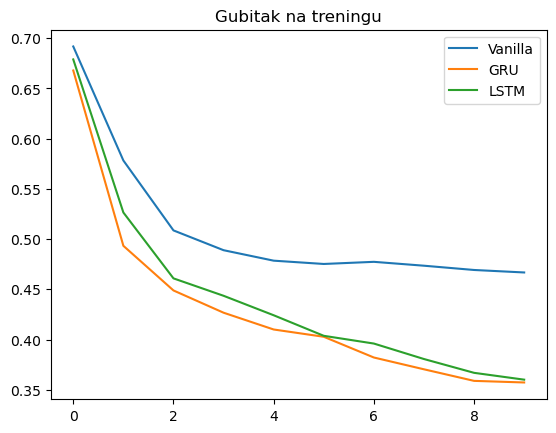

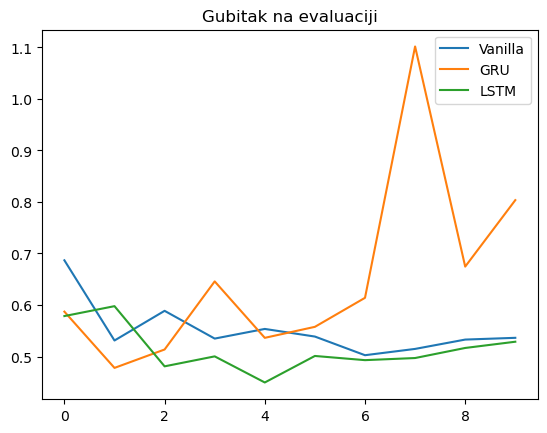

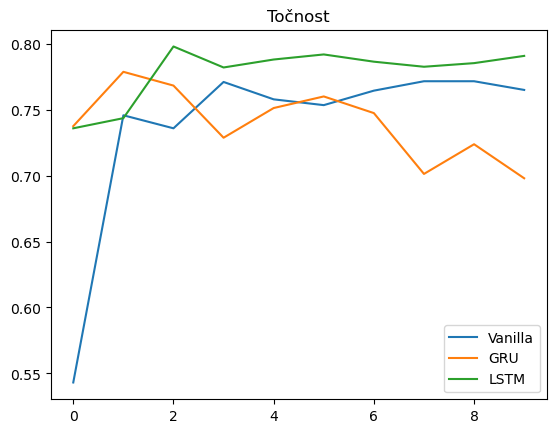

In [105]:
#testiranje vrsta ćelija

modes = ['Vanilla', 'GRU', 'LSTM']
#modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 10
#batch_size = 30
shuffle = True
clip = 0.25

file = open('zad4-modes.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nHiperparametri:\nHidden_size = 150\nnum_layers = 2\ndropout=0\nbidirectional=False\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('-----------------------------------\n')



acc_full = []
loss_train_full = []
loss_eval_full = []

for mode in modes:
    print('Mode = ' + mode)
    acc_vec = []
    loss_vec_t = []
    loss_vec_e = []
    
    model = ReturnModelImproved(150, 2, rnn_mode = mode)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    #treniranje
    for epoch in range(epochs):
        print('Epoha:', epoch)
        loss_train = 0
        N_batch = 0
        
        file.write('\nEpoha: ' + str(epoch+1) + '\n')
        
        model.train()
        loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
                
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            model.zero_grad()
            
            logits = model(embed_matrix(batch_X))
            logits = torch.flatten(logits)
            batch_y = batch_y.to(torch.float)
            loss = criterion(logits, batch_y)
            
            loss_train += loss.detach().numpy()
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        loss_vec_t.append(loss_train/N_batch)
        
        
        #evaluacija
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_eval = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                    
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1
            
            loss_vec_e.append(loss_eval/N_batch)
            N = TP + TN + FP + FN
            acc_vec.append((TP+TN)/N)
            file.write('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
            file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
            file.write('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
            file.write('Gubitak: ' + str(loss_eval/N_batch) + '\n')
    acc_full.append(acc_vec)
    loss_train_full.append(loss_vec_t)
    loss_eval_full.append(loss_vec_e)


    file.write('\nTest:')
    model.eval()
    TP = 0; TN = 0; FP = 0; FN = 0;
    loss_test = 0
    N_batch = 0
    with torch.no_grad():
        loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        data_X = []
        data_y = []
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            logits = torch.flatten(model.forward(embed_matrix(batch_X)))
            loss_test += criterion(logits, batch_y.to(torch.float)).numpy()
            logits = torch.tensor([1 if l > 0 else 0 for l in logits])
            for i in range(len(logits)):
                if(logits[i] == batch_y[i]):
                    if(batch_y[i] == 1):
                        TP += 1
                    else:
                        TN += 1
                else:
                    if(batch_y[i] == 1):
                        FN += 1
                    else:
                        FP += 1
        
        N = TP + TN + FP + FN
        file.write('Test acc:' + str((TP + TN)/N*100) + '%\n')
        file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + "\n")
        file.write('Matrica zabune:' + str([[TP, FN], [FP, TN]]) + '\n')
        file.write('Gubitak:' + str(loss_test/N_batch) + '\n')

    file.write('\n\n-------------------------------------------')
    
plt.title('Gubitak na treningu')
plt.plot(np.arange(epochs), loss_train_full[0], label='Vanilla')
plt.plot(np.arange(epochs), loss_train_full[1], label='GRU')
plt.plot(np.arange(epochs), loss_train_full[2], label='LSTM')
plt.legend()
plt.savefig('zad4-1-loss_train.png')
plt.show()

plt.title('Gubitak na evaluaciji')
plt.plot(np.arange(epochs), loss_eval_full[0], label='Vanilla')
plt.plot(np.arange(epochs), loss_eval_full[1], label='GRU')
plt.plot(np.arange(epochs), loss_eval_full[2], label='LSTM')
plt.legend()
plt.savefig('zad4-1-loss-eval.png')
plt.show()

plt.title('Točnost')
plt.plot(np.arange(epochs), acc_full[0], label='Vanilla')
plt.plot(np.arange(epochs), acc_full[1], label='GRU')
plt.plot(np.arange(epochs), acc_full[2], label='LSTM')
plt.legend()
plt.savefig('zad4-1-acc.png')
plt.show()


file.close()

In [12]:
hidden_states = [60, 150, 300]
num_layers = [2, 4, 6]
dropout = [0.1, 0.6, 0.9]
bidirectional = [True, False]

#combinations = [a, b, c, d] -> a = hidden_state, b = num_layers, c = dropout, d = bidirectional
#ideja pretraživanja -> isprobati zasebno utjecaj dropout-a -> 3 * 3 vrste_ćelije = 9 treninga
#                    -> isprobati kak kombinacija hidden_statea i num_layers utječe -> 9*3 = 18 treninga
#                    -> isprobati utjecaj bidirectional na jednu konfig -> 2*3 = 6
#                    -> za najbolji model hidd_state i num_layer isprobati kombinacije dropouta i bidirec -> 3*2 * 3 = 18

# sve skupa = 9 + 18 + 6 + 18 = puno previše!

#možda isprobati dropout i bidirect samo za jednu vrstu ćelije

Mode = LSTM
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7
Mode = LSTM
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7
Mode = LSTM
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
Epoha: 7


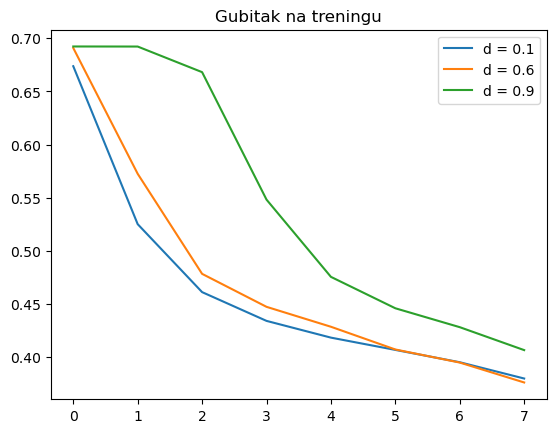

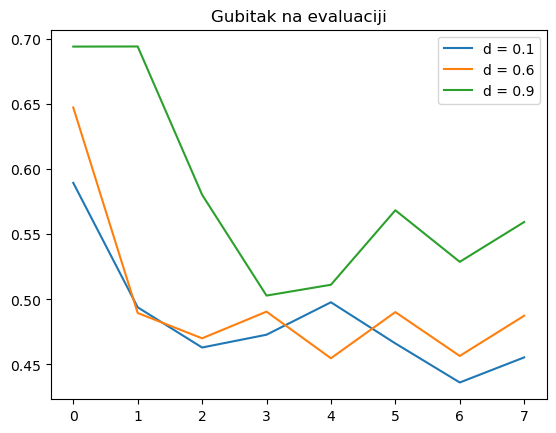

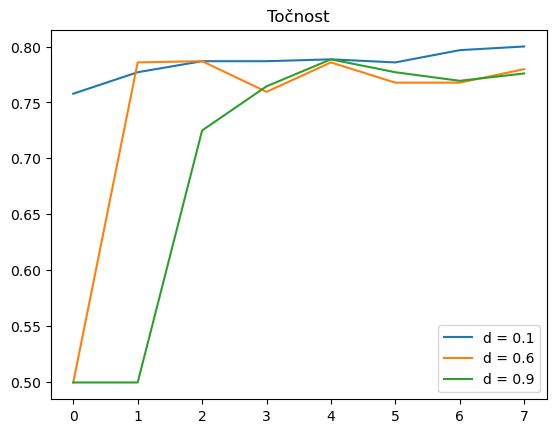

In [120]:
#testing dropout samo na LSTM

#modes = ['Vanilla', 'GRU', 'LSTM']
modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 8
#batch_size = 30
shuffle = True
clip = 0.25

file = open('zad4-dropout.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nHiperparametri:\nHidden_size = 150\nnum_layers = 2\nbidirectional=False\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('Cell type = LSTM\n')
file.write('-----------------------------------\n\n\n')



acc_full = []
loss_train_full = []
loss_eval_full = []

for d in dropout:
    print('Mode = LSTM')
    acc_vec = []
    loss_vec_t = []
    loss_vec_e = []
    
    model = ReturnModelImproved(150, 2, rnn_mode = 'LSTM', dropout = d)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    file.write('\nDropout = ' + str(d) + '\n\n')
    
    #treniranje
    for epoch in range(epochs):
        print('Epoha:', epoch)
        loss_train = 0
        N_batch = 0
        
        file.write('\nEpoha: ' + str(epoch+1) + '\n')
        
        model.train()
        loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
                
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            model.zero_grad()
            
            logits = model(embed_matrix(batch_X))
            logits = torch.flatten(logits)
            batch_y = batch_y.to(torch.float)
            loss = criterion(logits, batch_y)
            
            loss_train += loss.detach().numpy()
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        loss_vec_t.append(loss_train/N_batch)
        
        
        #evaluacija
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_eval = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                    
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1
            
            loss_vec_e.append(loss_eval/N_batch)
            N = TP + TN + FP + FN
            acc_vec.append((TP+TN)/N)
            file.write('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
            file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
            file.write('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
            file.write('Gubitak: ' + str(loss_eval/N_batch) + '\n')
    acc_full.append(acc_vec)
    loss_train_full.append(loss_vec_t)
    loss_eval_full.append(loss_vec_e)


    file.write('\nTest:')
    model.eval()
    TP = 0; TN = 0; FP = 0; FN = 0;
    loss_test = 0
    N_batch = 0
    with torch.no_grad():
        loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        data_X = []
        data_y = []
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            logits = torch.flatten(model.forward(embed_matrix(batch_X)))
            loss_test += criterion(logits, batch_y.to(torch.float)).numpy()
            logits = torch.tensor([1 if l > 0 else 0 for l in logits])
            for i in range(len(logits)):
                if(logits[i] == batch_y[i]):
                    if(batch_y[i] == 1):
                        TP += 1
                    else:
                        TN += 1
                else:
                    if(batch_y[i] == 1):
                        FN += 1
                    else:
                        FP += 1
        
        N = TP + TN + FP + FN
        file.write('Test acc:' + str((TP + TN)/N*100) + '%\n')
        file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + "\n")
        file.write('Matrica zabune:' + str([[TP, FN], [FP, TN]]) + '\n')
        file.write('Gubitak:' + str(loss_test/N_batch) + '\n')

    file.write('\n\n-------------------------------------------')
    
plt.title('Gubitak na treningu')
plt.plot(np.arange(epochs), loss_train_full[0], label='d = ' + str(dropout[0]))
plt.plot(np.arange(epochs), loss_train_full[1], label='d = ' + str(dropout[1]))
plt.plot(np.arange(epochs), loss_train_full[2], label='d = ' + str(dropout[2]))
plt.legend()
plt.savefig('zad4-dropout-loss_train.png')
plt.show()

plt.title('Gubitak na evaluaciji')
plt.plot(np.arange(epochs), loss_eval_full[0], label='d = ' + str(dropout[0]))
plt.plot(np.arange(epochs), loss_eval_full[1], label='d = ' + str(dropout[1]))
plt.plot(np.arange(epochs), loss_eval_full[2], label='d = ' + str(dropout[2]))
plt.legend()
plt.savefig('zad4-dropout-loss-eval.png')
plt.show()

plt.title('Točnost')
plt.plot(np.arange(epochs), acc_full[0], label='d = ' + str(dropout[0]))
plt.plot(np.arange(epochs), acc_full[1], label='d = ' + str(dropout[1]))
plt.plot(np.arange(epochs), acc_full[2], label='d = ' + str(dropout[2]))
plt.legend()
plt.savefig('zad4-dropout-acc.png')
plt.show()


file.close()

b = True
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6
b = False
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
Epoha: 5
Epoha: 6


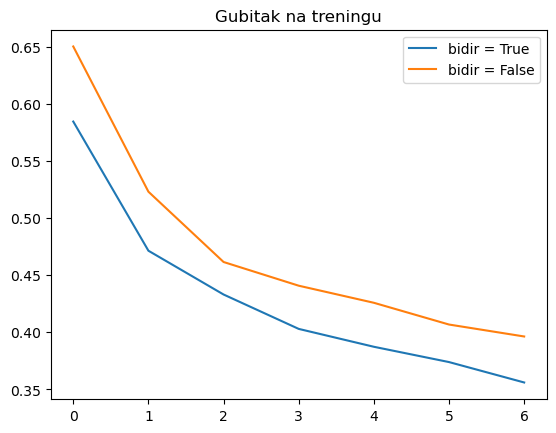

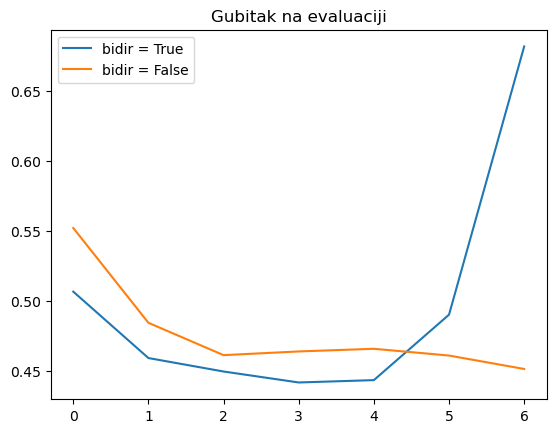

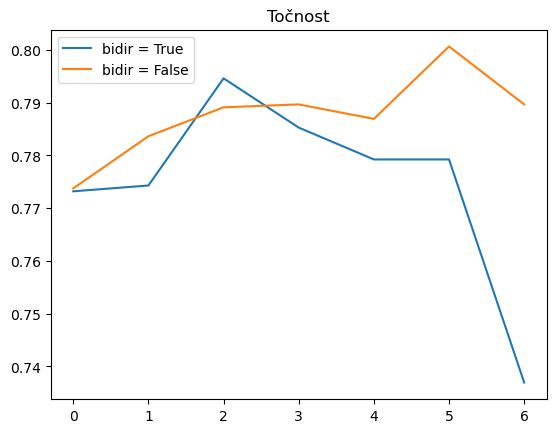

In [121]:
#testing bidirect samo na LSTM

#modes = ['Vanilla', 'GRU', 'LSTM']
modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 7
#batch_size = 30
shuffle = True
clip = 0.25

file = open('zad4-bidir.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nHiperparametri:\nHidden_size = 150\nnum_layers = 2\ndropout = 0\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('Cell type = LSTM\n')
file.write('-----------------------------------\n\n\n')



acc_full = []
loss_train_full = []
loss_eval_full = []

for b in bidirectional:
    print('b =', b)
    acc_vec = []
    loss_vec_t = []
    loss_vec_e = []
    
    model = ReturnModelImproved(150, 2, rnn_mode = 'LSTM', bidirectional = b)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    file.write('\nBidirectional = ' + str(b) + '\n\n')
    
    #treniranje
    for epoch in range(epochs):
        print('Epoha:', epoch)
        loss_train = 0
        N_batch = 0
        
        file.write('\nEpoha: ' + str(epoch+1) + '\n')
        
        model.train()
        loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
                
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            model.zero_grad()
            
            logits = model(embed_matrix(batch_X))
            logits = torch.flatten(logits)
            batch_y = batch_y.to(torch.float)
            loss = criterion(logits, batch_y)
            
            loss_train += loss.detach().numpy()
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        loss_vec_t.append(loss_train/N_batch)
        
        
        #evaluacija
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_eval = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                    
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1
            
            loss_vec_e.append(loss_eval/N_batch)
            N = TP + TN + FP + FN
            acc_vec.append((TP+TN)/N)
            file.write('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
            file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
            file.write('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
            file.write('Gubitak: ' + str(loss_eval/N_batch) + '\n')
    acc_full.append(acc_vec)
    loss_train_full.append(loss_vec_t)
    loss_eval_full.append(loss_vec_e)


    file.write('\nTest:')
    model.eval()
    TP = 0; TN = 0; FP = 0; FN = 0;
    loss_test = 0
    N_batch = 0
    with torch.no_grad():
        loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        data_X = []
        data_y = []
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            logits = torch.flatten(model.forward(embed_matrix(batch_X)))
            loss_test += criterion(logits, batch_y.to(torch.float)).numpy()
            logits = torch.tensor([1 if l > 0 else 0 for l in logits])
            for i in range(len(logits)):
                if(logits[i] == batch_y[i]):
                    if(batch_y[i] == 1):
                        TP += 1
                    else:
                        TN += 1
                else:
                    if(batch_y[i] == 1):
                        FN += 1
                    else:
                        FP += 1
        
        N = TP + TN + FP + FN
        file.write('Test acc:' + str((TP + TN)/N*100) + '%\n')
        file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + "\n")
        file.write('Matrica zabune:' + str([[TP, FN], [FP, TN]]) + '\n')
        file.write('Gubitak:' + str(loss_test/N_batch) + '\n')

    file.write('\n\n-------------------------------------------')
    
plt.title('Gubitak na treningu')
plt.plot(np.arange(epochs), loss_train_full[0], label='bidir = ' + str(bidirectional[0]))
plt.plot(np.arange(epochs), loss_train_full[1], label='bidir = ' + str(bidirectional[1]))
plt.legend()
plt.savefig('zad4-bidir-loss_train.png')
plt.show()

plt.title('Gubitak na evaluaciji')
plt.plot(np.arange(epochs), loss_eval_full[0], label='bidir = ' + str(bidirectional[0]))
plt.plot(np.arange(epochs), loss_eval_full[1], label='bidir = ' + str(bidirectional[1]))
plt.legend()
plt.savefig('zad4-bidir-loss-eval.png')
plt.show()

plt.title('Točnost')
plt.plot(np.arange(epochs), acc_full[0], label='bidir = ' + str(bidirectional[0]))
plt.plot(np.arange(epochs), acc_full[1], label='bidir = ' + str(bidirectional[1]))
plt.legend()
plt.savefig('zad4-bidir-acc.png')
plt.show()


file.close()

60 2
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
60 4
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
60 6
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
150 2
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
150 4
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
150 6
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
300 2
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
300 4
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
300 6
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4


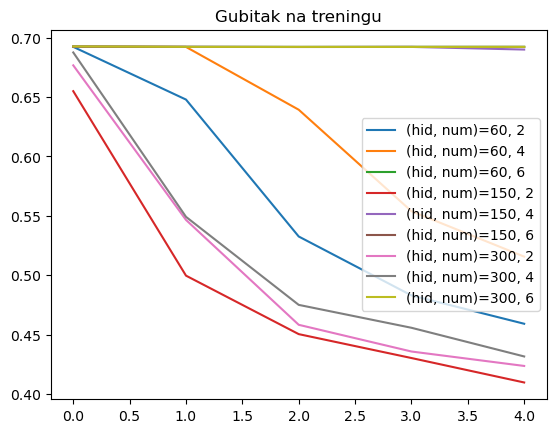

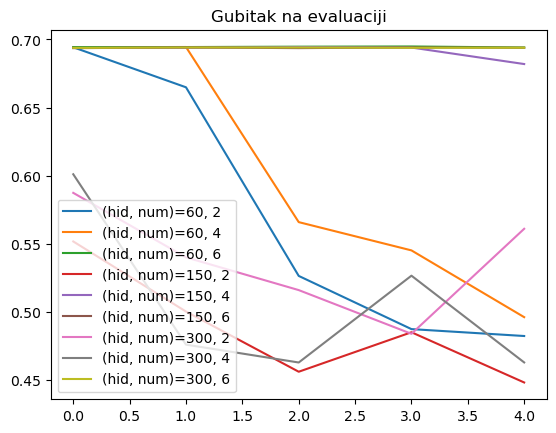

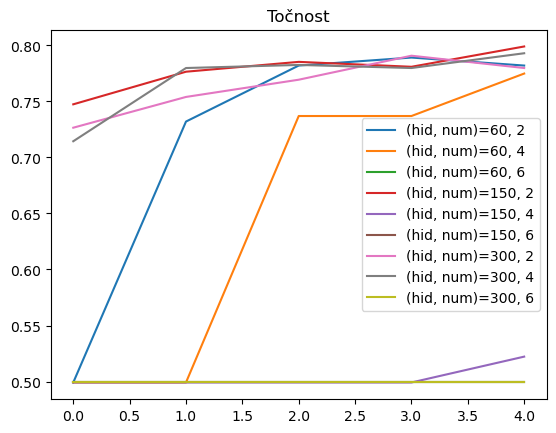

In [13]:
#grid search za hidden_state i num_layers - samo LSTM:


#modes = ['Vanilla', 'GRU', 'LSTM']
modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 5
#batch_size = 30
shuffle = True
clip = 0.25

file = open('zad4-grid.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nTrazimo hidden_state i num_layers hiperp.\n')
file.write('\nHiperparametri:\nbidir = False\ndropout = 0\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('Cell type = LSTM\n')
file.write('-----------------------------------\n\n\n')



acc_full = []
loss_train_full = []
loss_eval_full = []

for h in hidden_states:
    for num in num_layers:
        print(h, num)

        acc_vec = []
        loss_vec_t = []
        loss_vec_e = []
    
        model = ReturnModelImproved(h, num, rnn_mode = 'LSTM')

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        file.write('(hidden_state, num_layers) = ' + str(h) + str(num) + '\n\n')
    
        #treniranje
        for epoch in range(epochs):
            print('Epoha:', epoch)
            loss_train = 0
            N_batch = 0

            file.write('\nEpoha: ' + str(epoch+1) + '\n')

            model.train()
            loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)

            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break

                N_batch += 1
                batch_X, batch_y, batch_l = batch
                model.zero_grad()

                logits = model(embed_matrix(batch_X))
                logits = torch.flatten(logits)
                batch_y = batch_y.to(torch.float)
                loss = criterion(logits, batch_y)

                loss_train += loss.detach().numpy()

                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

            loss_vec_t.append(loss_train/N_batch)


            #evaluacija
            model.eval()
            TP = 0; TN = 0; FP = 0; FN = 0;
            loss_eval = 0
            N_batch = 0
            with torch.no_grad():
                loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
                iterable = iter(loader)
                data_X = []
                data_y = []
                while(True):
                    batch = next(iterable, -1)
                    if(batch == -1):
                        break

                    N_batch += 1
                    batch_X, batch_y, batch_l = batch

                    logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                    loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                    logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                    for i in range(len(logits)):
                        if(logits[i] == batch_y[i]):
                            if(batch_y[i] == 1):
                                TP += 1
                            else:
                                TN += 1
                        else:
                            if(batch_y[i] == 1):
                                FN += 1
                            else:
                                FP += 1

                loss_vec_e.append(loss_eval/N_batch)
                N = TP + TN + FP + FN
                acc_vec.append((TP+TN)/N)
                file.write('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
                file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
                file.write('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
                file.write('Gubitak: ' + str(loss_eval/N_batch) + '\n')
        acc_full.append(acc_vec)
        loss_train_full.append(loss_vec_t)
        loss_eval_full.append(loss_vec_e)


        file.write('\nTest:')
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_test = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_test += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1

            N = TP + TN + FP + FN
            file.write('Test acc:' + str((TP + TN)/N*100) + '%\n')
            file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + "\n")
            file.write('Matrica zabune:' + str([[TP, FN], [FP, TN]]) + '\n')
            file.write('Gubitak:' + str(loss_test/N_batch) + '\n')

        file.write('\n\n-------------------------------------------')
    

plt.title('Gubitak na treningu')
for i in range(len(loss_train_full)):
    plt.plot(np.arange(epochs), loss_train_full[i], label='(hid, num)=' + str(hidden_states[int(i/3)]) + ', '+ str(num_layers[i%3]))
plt.legend()
plt.savefig('zad4-grid-loss_train.png')
plt.show()

plt.title('Gubitak na evaluaciji')
for i in range(len(loss_eval_full)):
    plt.plot(np.arange(epochs), loss_eval_full[i], label='(hid, num)=' + str(hidden_states[int(i/3)]) + ', '+ str(num_layers[i%3]))
plt.legend()
plt.savefig('zad4-grid-loss-eval.png')
plt.show()

plt.title('Točnost')
for i in range(len(acc_full)):
    plt.plot(np.arange(epochs), acc_full[i], label='(hid, num)=' + str(hidden_states[int(i/3)]) + ', '+ str(num_layers[i%3]))
plt.legend()
plt.savefig('zad4-grid-acc.png')
plt.show()
    


file.close()

True 0.1
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
True 0.5
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
False 0.1
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4
False 0.5
Epoha: 0
Epoha: 1
Epoha: 2
Epoha: 3
Epoha: 4


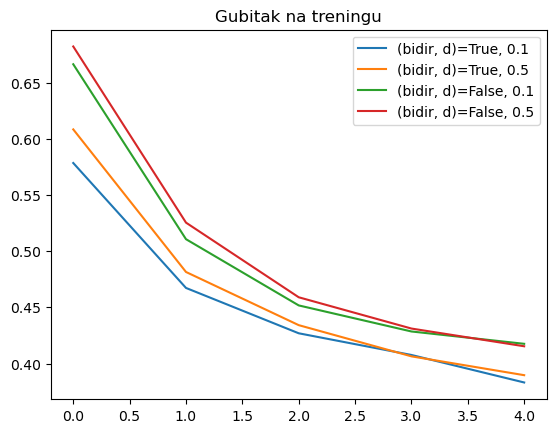

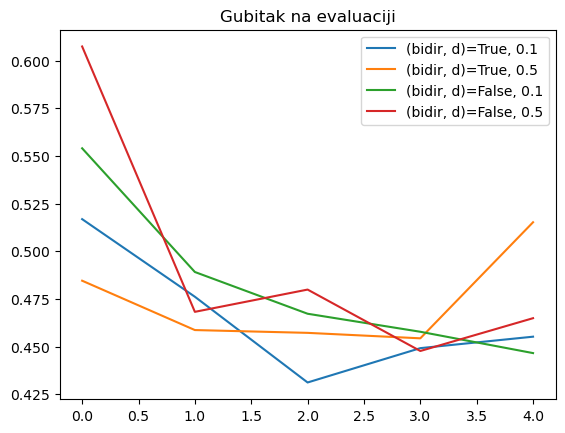

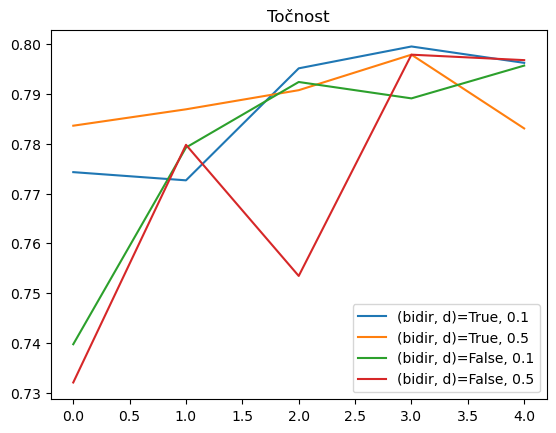

In [18]:
#grid search za dropout i bidir na optimalnim hidd_size i num_layers - samo LSTM:


#modes = ['Vanilla', 'GRU', 'LSTM']
modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 5
#batch_size = 30
shuffle = True
clip = 0.25

file = open('zad4-grid-b-d.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nTrazimo bidir i dropout za optimalnu strukturu\n')
file.write('\nHiperparametri:\nhidden_size = 150\nnum_layers = 2\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('Cell type = LSTM\n')
file.write('-----------------------------------\n\n\n')



acc_full = []
loss_train_full = []
loss_eval_full = []

bidir = [True, False]
drop = [0.1, 0.5]

for b in bidir:
    for d in drop:
        print(b, d)

        acc_vec = []
        loss_vec_t = []
        loss_vec_e = []
    
        model = ReturnModelImproved(150, 2, rnn_mode = 'LSTM', dropout = d, bidirectional = b)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        file.write('(bidir, dropout) = ' + str(b) + str(d) + '\n\n')
    
        #treniranje
        for epoch in range(epochs):
            print('Epoha:', epoch)
            loss_train = 0
            N_batch = 0

            file.write('\nEpoha: ' + str(epoch+1) + '\n')

            model.train()
            loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)

            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break

                N_batch += 1
                batch_X, batch_y, batch_l = batch
                model.zero_grad()

                logits = model(embed_matrix(batch_X))
                logits = torch.flatten(logits)
                batch_y = batch_y.to(torch.float)
                loss = criterion(logits, batch_y)

                loss_train += loss.detach().numpy()

                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

            loss_vec_t.append(loss_train/N_batch)


            #evaluacija
            model.eval()
            TP = 0; TN = 0; FP = 0; FN = 0;
            loss_eval = 0
            N_batch = 0
            with torch.no_grad():
                loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
                iterable = iter(loader)
                data_X = []
                data_y = []
                while(True):
                    batch = next(iterable, -1)
                    if(batch == -1):
                        break

                    N_batch += 1
                    batch_X, batch_y, batch_l = batch

                    logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                    loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                    logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                    for i in range(len(logits)):
                        if(logits[i] == batch_y[i]):
                            if(batch_y[i] == 1):
                                TP += 1
                            else:
                                TN += 1
                        else:
                            if(batch_y[i] == 1):
                                FN += 1
                            else:
                                FP += 1

                loss_vec_e.append(loss_eval/N_batch)
                N = TP + TN + FP + FN
                acc_vec.append((TP+TN)/N)
                file.write('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
                file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
                file.write('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
                file.write('Gubitak: ' + str(loss_eval/N_batch) + '\n')
        acc_full.append(acc_vec)
        loss_train_full.append(loss_vec_t)
        loss_eval_full.append(loss_vec_e)


        file.write('\nTest:')
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_test = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(testSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_test += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1

            N = TP + TN + FP + FN
            file.write('Test acc:' + str((TP + TN)/N*100) + '%\n')
            file.write('F1: ' + str(2*TP/(2*TP + FP + FN)) + "\n")
            file.write('Matrica zabune:' + str([[TP, FN], [FP, TN]]) + '\n')
            file.write('Gubitak:' + str(loss_test/N_batch) + '\n')

        file.write('\n\n-------------------------------------------')
    

plt.title('Gubitak na treningu')
for i in range(len(loss_train_full)):
    plt.plot(np.arange(epochs), loss_train_full[i], label='(bidir, d)=' + str(bidir[int(i/2)]) + ', '+ str(drop[i%2]))
plt.legend()
plt.savefig('zad4-grid-bd-loss_train.png')
plt.show()

plt.title('Gubitak na evaluaciji')
for i in range(len(loss_eval_full)):
    plt.plot(np.arange(epochs), loss_eval_full[i], label='(bidir, d)=' + str(bidir[int(i/2)]) + ', '+ str(drop[i%2]))
plt.legend()
plt.savefig('zad4-grid-bd-loss-eval.png')
plt.show()

plt.title('Točnost')
for i in range(len(acc_full)):
    plt.plot(np.arange(epochs), acc_full[i], label='(bidir, d)=' + str(bidir[int(i/2)]) + ', '+ str(drop[i%2]))
plt.legend()
plt.savefig('zad4-grid-bd-acc.png')
plt.show()
    


file.close()

In [11]:
#proba - troslojni
#modes = ['Vanilla', 'GRU', 'LSTM']
modes = ['LSTM']

seed = 698
torch.manual_seed(seed)
np.random.seed(seed)

epochs = 10
#batch_size = 30
shuffle = True
clip = 0.25

'''file = open('zad4-modes.txt', 'w')
file.write('Seed = ' + str(seed))
file.write('\nHiperparametri:\nHidden_size = 150\nnum_layers = 2\ndropout=0\nbidirectional=False\n')
file.write('Gubitak = BCEWithLogitsLoss\nOptimizator = Adam, lr = 1e-4\n')
file.write('Broj epoha = ' + str(epochs) + '\nbatch_size_train = 10, batch_size_test/eval = 32\nshuffle = True\nclip = 0.25\n')
file.write('-----------------------------------\n')'''



acc_full = []
loss_train_full = []
loss_eval_full = []

for mode in modes:
    print('Mode = ' + mode)
    acc_vec = []
    loss_vec_t = []
    loss_vec_e = []
    
    model = ReturnModelImproved(150, 4, rnn_mode = mode)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    #treniranje
    for epoch in range(epochs):
        print('Epoha:', epoch)
        loss_train = 0
        N_batch = 0
        
        #file.write('\nEpoha: ' + str(epoch+1) + '\n')
        
        model.train()
        loader = DataLoader(trainSet, batch_size = 10, shuffle = shuffle, collate_fn = pad_collate_fn)
        iterable = iter(loader)
        
        while(True):
            batch = next(iterable, -1)
            if(batch == -1):
                break
                
            N_batch += 1
            batch_X, batch_y, batch_l = batch
            model.zero_grad()
            
            logits = model(embed_matrix(batch_X))
            logits = torch.flatten(logits)
            batch_y = batch_y.to(torch.float)
            loss = criterion(logits, batch_y)
            
            loss_train += loss.detach().numpy()
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        loss_vec_t.append(loss_train/N_batch)
        
        
        #evaluacija
        model.eval()
        TP = 0; TN = 0; FP = 0; FN = 0;
        loss_eval = 0
        N_batch = 0
        with torch.no_grad():
            loader = DataLoader(evalSet, batch_size = 32, shuffle = shuffle, collate_fn = pad_collate_fn)
            iterable = iter(loader)
            data_X = []
            data_y = []
            while(True):
                batch = next(iterable, -1)
                if(batch == -1):
                    break
                    
                N_batch += 1
                batch_X, batch_y, batch_l = batch
                
                logits = torch.flatten(model.forward(embed_matrix(batch_X)))
                loss_eval += criterion(logits, batch_y.to(torch.float)).numpy()
                logits = torch.tensor([1 if l > 0 else 0 for l in logits])
                for i in range(len(logits)):
                    if(logits[i] == batch_y[i]):
                        if(batch_y[i] == 1):
                            TP += 1
                        else:
                            TN += 1
                    else:
                        if(batch_y[i] == 1):
                            FN += 1
                        else:
                            FP += 1
            
            loss_vec_e.append(loss_eval/N_batch)
            N = TP + TN + FP + FN
            acc_vec.append((TP+TN)/N)
            print('Eval acc: ' + str((TP + TN)/N*100) + '%\n')
            print('F1: ' + str(2*TP/(2*TP + FP + FN)) + '\n')
            print('Matrica zabune: ' + str([[TP, FN], [FP, TN]]) + '\n')
            print('Gubitak: ' + str(loss_eval/N_batch) + '\n')
    acc_full.append(acc_vec)
    loss_train_full.append(loss_vec_t)
    loss_eval_full.append(loss_vec_e)


    
    
plt.title('Gubitak na treningu')
plt.plot(np.arange(epochs), loss_train_full[0], label='LSTM')
plt.legend()
plt.show()

plt.title('Gubitak na evaluaciji')
plt.plot(np.arange(epochs), loss_eval_full[0], label='LSTM')
plt.legend()
plt.show()

plt.title('Točnost')
plt.plot(np.arange(epochs), acc_full[0], label='LSTM')
plt.legend()
plt.show()


Mode = LSTM
Epoha: 0
Eval acc: 72.7622185612301%

F1: 0.7213483146067415

Matrica zabune: [[642, 270], [226, 683]]

Gubitak: 0.6145744323730469

Epoha: 1
Eval acc: 77.81438769906644%

F1: 0.7688787185354691

Matrica zabune: [[672, 240], [164, 745]]

Gubitak: 0.4919786348677518

Epoha: 2


KeyboardInterrupt: 